In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns

from utils.load_data import load_data, load_gt_data
from utils.preprocessing import preprocess_data, preprocess_gt_data
from models.MLP import MLP
from models.KalmanFilterMLP import KalmanFilterMLP
from models.LinearModels import OLS
from utils.downward_trend_removal import detrend_gts

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
SEED = 0
EPS = 1e-6

TEST_ALL_GT_DATA = False # If set to True, the model will be trained on all available data and predictions will be made for all available GT data

TRAIN_PROPORTION = 0.9 if not TEST_ALL_GT_DATA else 1
PAST_GDPS = [] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
PAST_GTS = [4] if not TEST_ALL_GT_DATA else None # e.g. range(1, 3) or [1, 2]
MODE = None # None | "pct" | "diff"

DETREND = True

In [43]:
data, all_gdps = load_data()
gt_data = detrend_gts(load_gt_data()) if DETREND else load_gt_data()

print(f"Data shape: {data.shape}")

X_train, y_train, X_valid, y_valid, country_train, country_valid,  X_means, X_stds, y_mean, y_std, min_date = preprocess_data(
    data=data, 
    epsilon=EPS,
    train_pct=TRAIN_PROPORTION, 
    mode=MODE, all_gdps=all_gdps, 
    past_gdp_lags=PAST_GDPS, 
    all_gts=gt_data, 
    past_gt_lags=PAST_GTS
)

if TEST_ALL_GT_DATA:
    X_valid, country_valid = preprocess_gt_data(gt_data, EPS, X_means, X_stds, min_date=min_date)

X_train[country_train == "Switzerland"].head()

Data shape: (550, 98)
(0, 96)
Dropped 550 rows because of missing lagged Google Trends values
X_train shape : (0, 189)
X_valid shape : (0, 189)
y_train shape : (0,)
y_valid shape : (0,)


/Users/nathangromb/opt/miniconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


,date,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,...,High_tech_average_lag_4,Agile_software_development_average_lag_4,Subsidy_average_lag_4,Sustainability_average_lag_4,Open_innovation_average_lag_4,Industrial_park_average_lag_4,Semiconductor_average_lag_4,Artificial_intelligence_average_lag_4,International_Financial_Reporting_Standards_average_lag_4,Employment_average_lag_4


In [44]:
y_train[country_train == "Switzerland"].head().to_frame()

,GDP


In [45]:
models = {
    'MLP': MLP(seed=SEED, n_models=5),
    'KF on MLP': KalmanFilterMLP(seed=SEED, nb_init_samples=5),
    'OLS': OLS(),
}

y_pred_train = {}
y_pred_valid = {}
for model in models:
    # Fit and predict on training and validation data
    print(f"Training {model}")

    if 'KF' in model:
        models[model].fit(X_train, y_train, countries=country_train)
    else: 
        models[model].fit(X_train, y_train)


    y_pred_train[model] = models[model].predict(X_train, countries=country_train) if 'KF' in model else models[model].predict(X_train)
    y_pred_valid[model] = models[model].predict(X_valid, countries=country_valid) if 'KF' in model else models[model].predict(X_valid)

Training MLP


ValueError: Found array with 0 sample(s) (shape=(0, 189)) while a minimum of 1 is required by MLPRegressor.

MLP :


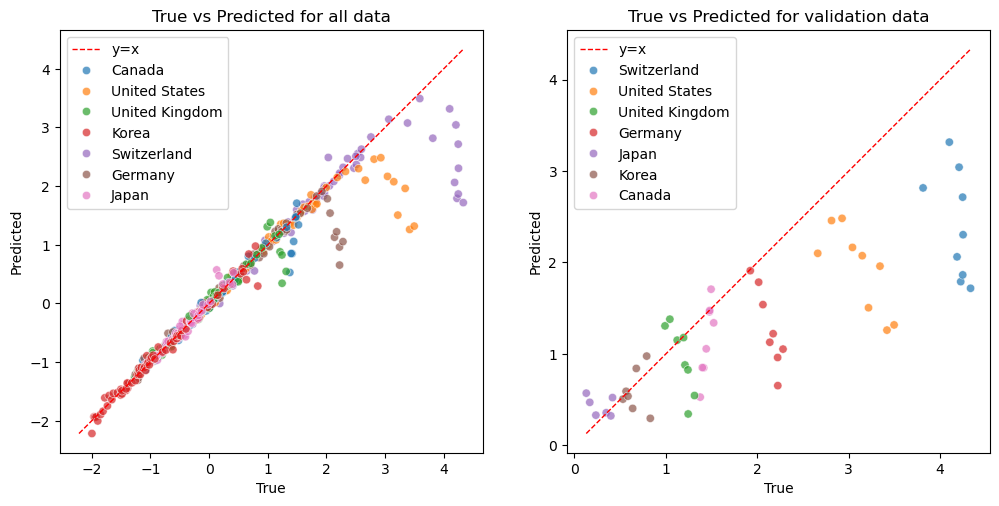

KF on MLP :


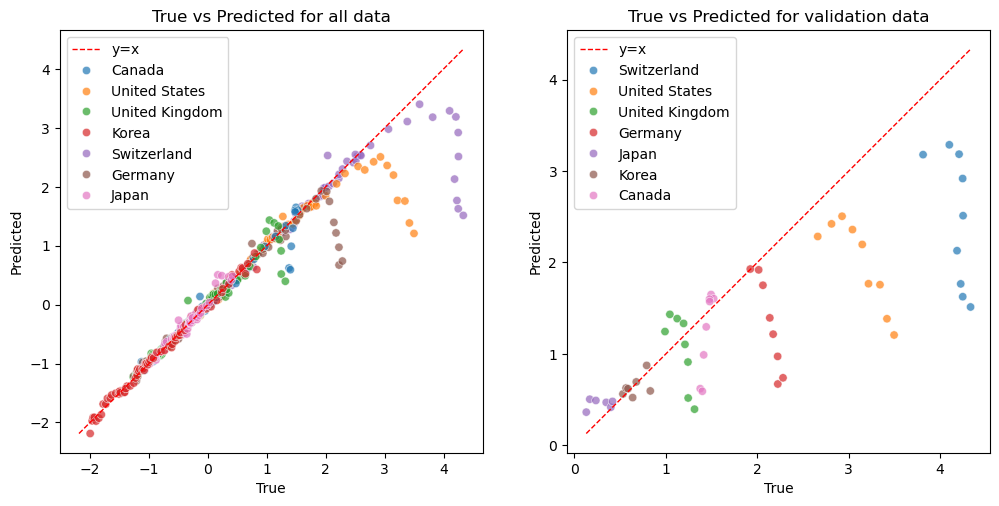

OLS :


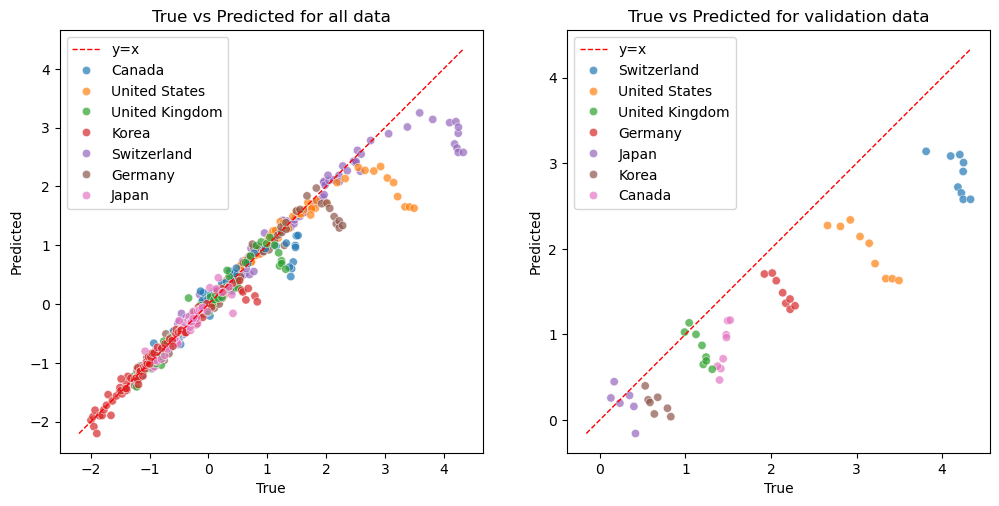

In [ ]:
# Associate the result by country
y_pred_valid_country = pd.DataFrame(dict({'date': X_valid['date'], 'country': country_valid, 'True GDP': y_valid}, **y_pred_valid))
y_pred_train_country = pd.DataFrame(dict({'date': X_train['date'], 'country': country_train, 'True GDP': y_train}, **y_pred_train))

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_valid_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["True GDP"] + [model for model in models],
    var_name="Type", value_name="Value"
)

def plot_predictions_against_true(true_key="True GDP", pred_key="y_pred"):
    plt.figure(figsize=(12, 6))

    ax = plt.subplot(1, 2, 1)
    ax.set_box_aspect(1)

    line_min = np.min([np.min(predictions[true_key]), np.min(predictions[pred_key])])
    line_max = np.max([np.max(predictions[true_key]), np.max(predictions[pred_key])])
    plt.plot([line_min, line_max], [line_min, line_max], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=predictions, hue='country', alpha=0.7)
    plt.title('True vs Predicted for all data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    ax = plt.subplot(1, 2, 2)
    ax.set_box_aspect(1)

    line_min = np.min([np.min(y_pred_valid_country[true_key]), np.min(y_pred_valid_country[pred_key])])
    line_max = np.max([np.max(y_pred_valid_country[true_key]), np.max(y_pred_valid_country[pred_key])])
    plt.plot([line_min, line_max], [line_min, line_max], color='red', linewidth=1, linestyle='--', label='y=x')
    sns.scatterplot(x=true_key, y=pred_key, data=y_pred_valid_country, hue='country', alpha=0.7)
    plt.title('True vs Predicted for validation data')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.legend()

    plt.show()

if not TEST_ALL_GT_DATA:
    for model in models:
        print(f'{model} :')
        plot_predictions_against_true(true_key="True GDP", pred_key=model)

In [ ]:
# Function to plot data with confidence intervals for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = filtered_data[filtered_data['Type'] == 'True GDP']['date'].quantile(TRAIN_PROPORTION)

    plt.figure(figsize=(12, 6))

    # Plot predictions and true values
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )

    # Add a vertical line to indicate where validation starts
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({(TRAIN_PROPORTION)*100:.0f}%)')

    # Enhancing the plot
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the updated plot function
interact(plot_by_country, selected_country=dropdown)

# Calculate Mean Squared Error
for model in models:
    print(f"{model} : Training  ME: {mean_squared_error(y_train, y_pred_train[model]):.4f}", end="")
    if not TEST_ALL_GT_DATA:
        print(f", Validation MSE: {mean_squared_error(y_valid, y_pred_valid[model]):.4f}")
    else:
        print()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'United States', 'United Kingdom', '…

MLP : Training  ME: 0.0045, Validation MSE: 1.1064
KF on MLP : Training  ME: 0.0044, Validation MSE: 1.0790
OLS : Training  ME: 0.0116, Validation MSE: 0.7583
